Firstly, import the fortran disk model routines and the python likelihood functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profileell,profilecirc,profileell2d,profilecirc2d
from diskfit import likelihood, utils
from scipy.optimize import minimize

Load the continuum subtracted spectrum. Establish the redshift and narrow line width in Angstroms. 

In [2]:
fn = '../data/ZTF18aahiqst_subtracted.txt'
wl,flux,fluxerr = utils.readspec(fn)
z = 0.0745
narrowmu = 3.9

Extract the region of the spectrum containing the double-peaked profile, and store the size of the spectrum in npix

In [3]:
olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
wavemin = 6300  # minimum wavelength (Angstrom)
wavemax = 6900  # maximum wavelength (Angstrom)
wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
indwave = np.argwhere((wave>wavemin)&(wave<wavemax))[:,0]
wave = np.asarray(wave[indwave],dtype=np.float64)
flux = flux[indwave]
fluxerr = fluxerr[indwave]
npix = wave.shape[0]

Set all the parameters which will remain fixed to pre-determined values during the fitting

In [4]:
# No fixed parameters in this example



Create a dictionary of the fixed parameter names and values

In [5]:
fixed_labels = []
fixed_values = []
fixed = dict(zip(fixed_labels,fixed_values))

Set initial guesses for the parameters to be fitted

In [6]:
broadmu = olambda # Central broad line wavelength in Angstrom
width = 50 # Gaussian width in Angstrom

Create a dictionary of fitted parameter names and values

In [7]:
fitted_labels = ['broadmu','width']
initial = [broadmu, width]
fitted = dict(zip(fitted_labels,initial))

Set wavelengths of narrow emission lines to be included in the fit and create the array of line profiles

In [8]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]

Plot initial model against spectrum

In [9]:
modelguess = likelihood.model_linefit_broad(initial, wave, flux, fluxerr, lines, narrowmu, fixed, fitted)

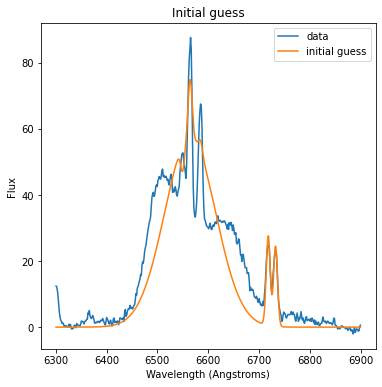

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(6,6))
plt.plot(wave,flux,label='data')
plt.plot(wave,modelguess,label='initial guess')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

Establish bounds for fitted parameters. These will be used to make a uniform prior.

In [11]:
broadmumax = broadmu-20
broadmumin= broadmu+20
widthmin = narrowmu*2
widthmax = 150
diskmins = [broadmumin,widthmin]
diskmax = [broadmumax,widthmax]

In [12]:
lp = likelihood.logprob_broad(wave, flux, fluxerr, lines, narrowmu, fixed, fitted, diskmins, diskmax)

Use scipy.optimize.minimize to find a simple solution for the fitted parameters

In [13]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)
print('Best-fit parameter values', soln.x)

Best-fit parameter values [6566.61500855   72.99004596]


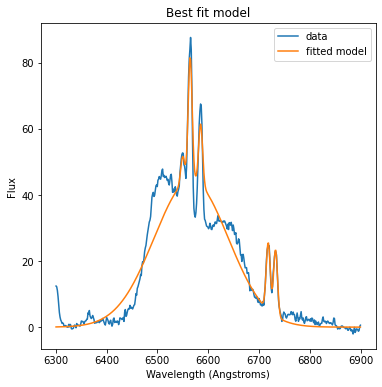

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(6,6))
plt.plot(wave,flux,label='data')
plt.plot(wave,modelfit,label='fitted model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

Now import the emcee module to sample the parameter space, with walkers initialized around the best fit parameters from the previous step. Run the sampler for 1000 iterations and save the progress to file. 

In [17]:
import emcee
pos = soln.x + 1e-2 * soln.x * np.random.randn(20, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='broad_emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 400, progress=True)

100%|███████████████████████████████████| 400/400 [00:26<00:00, 14.98it/s]


State([[6566.59304457   72.55356521]
 [6566.74023681   72.65321968]
 [6566.49927045   73.00716771]
 [6567.07605777   73.5679859 ]
 [6566.94428721   72.8499008 ]
 [6566.70301549   72.81593775]
 [6566.36417304   72.96696619]
 [6566.19707398   73.54020371]
 [6566.76972425   72.58959609]
 [6566.53227864   72.84291891]
 [6566.71607343   72.78071485]
 [6566.45719924   72.62962106]
 [6566.6970321    72.59461329]
 [6566.62426604   72.49523452]
 [6567.51426144   73.76970756]
 [6567.07526557   73.43375179]
 [6566.48273256   73.30566104]
 [6566.24443453   72.85483271]
 [6566.80620981   73.22010193]
 [6566.70048179   73.06156051]], log_prob=[-2887.02230316 -2886.84335095 -2886.07697606 -2887.98640253
 -2886.8005645  -2886.25743264 -2886.29910927 -2889.24702178
 -2887.209      -2886.1149179  -2886.36314357 -2886.65324884
 -2887.00355291 -2887.36788923 -2890.96601458 -2887.44772869
 -2886.76563046 -2886.62176578 -2886.32722041 -2886.0464549 ], blobs=None, random_state=('MT19937', array([3506503328, 

Print the parameters and uncertainties found by the sampler

In [18]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=200, flat=True)
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Make a corner plot of the parameter samples

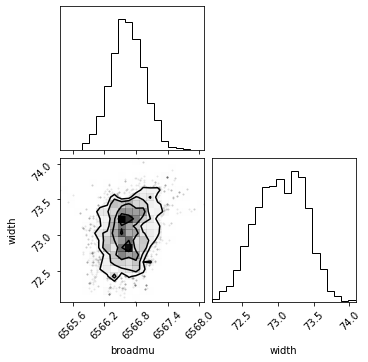

In [19]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

Plot the sampler chains 

<Figure size 432x432 with 0 Axes>

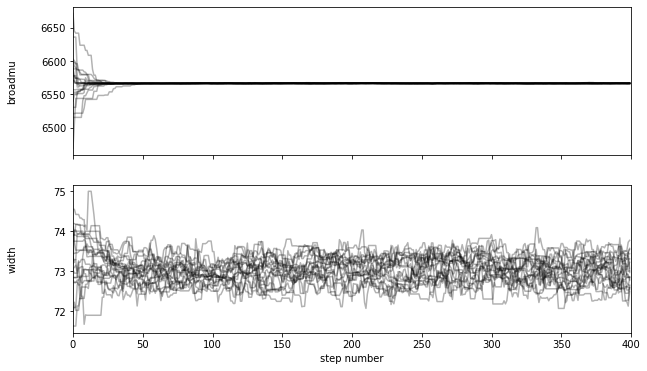

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

Plot the range of good fits found by the sampler

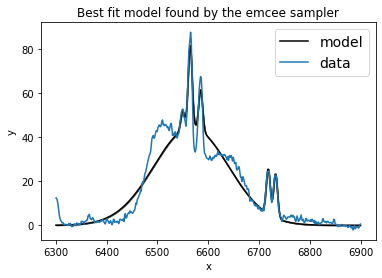

<Figure size 432x288 with 0 Axes>

In [21]:
from ultranest.plot import PredictionBand
band = PredictionBand(wave)
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    modelfit = lp.test(sample)
    band.add(modelfit)
    plt.plot(wave,modelfit,alpha=0.1)

band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wave,flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()